# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [1]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


In [2]:
!{sys.executable} -m pip install tqdm


### Import Dependencies

# System libraries

In [4]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
if "workspace" in os.getcwd():
    ROOT = "/workspace"
elif "/group/cake" in os.getcwd(): 
    ROOT = "/group/cake"


### Initialize Environment

In [6]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder=ROOT)
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /group/cake
 - Project folder: /group/cake/our-git-project
 - Datasets folder: /data/training
 - Models folder: /group/cake/our-git-project/models
 - Experiments folder: /group/cake/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [7]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (1.0, 1.0, 1.0)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation': 0.35
}


### Load Meta Data

In [8]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/data/training/A001_orig.nii.gz,/data/training/A001_masks.nii.gz,/data/training/A001_vessel.nii.gz,/data/training/A001_labeledMasks.nii.gz
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/data/training/A003_orig.nii.gz,/data/training/A003_masks.nii.gz,/data/training/A003_vessel.nii.gz,/data/training/A003_labeledMasks.nii.gz
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/data/training/A005_orig.nii.gz,/data/training/A005_masks.nii.gz,/data/training/A005_vessel.nii.gz,/data/training/A005_labeledMasks.nii.gz
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/data/training/A006_orig.nii.gz,/data/training/A006_masks.nii.gz,/data/training/A006_vessel.nii.gz,/data/training/A006_labeledMasks.nii.gz
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/data/training/A008_orig.nii.gz,/data/training/A008_masks.nii.gz,/data/training/A008_vessel.nii.gz,/data/training/A008_labeledMasks.nii.gz


### Load & Split MRI Data

In [9]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
# case_list = ["A009","A010","A012","A013","A014","A015"]
# df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

109
98
         Images
-----  --------
All         109
Train        87
Val          11
Test         11



  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [10]:
from aneurysm_utils import preprocessing

most_common_shape=preprocessing.check_mri_shapes(mri_imgs_train)



Most common:
(139, 139, 120):      75
(139, 139, 119):       5
(70, 70, 60):       5
(108, 108, 96):       2


## Transform & Preprocess Data

In [11]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...
[INFO] Preprocessing: Intensity Segmentation...


In [12]:
size =(139, 139, 120)#(47,47,41)#
print(size)
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != size]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != size]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != size]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))


(139, 139, 120)
Most common:
(139, 139, 120):      75
(array([0., 1.], dtype=float32), array([2318414,     106]))


### Optional: View image


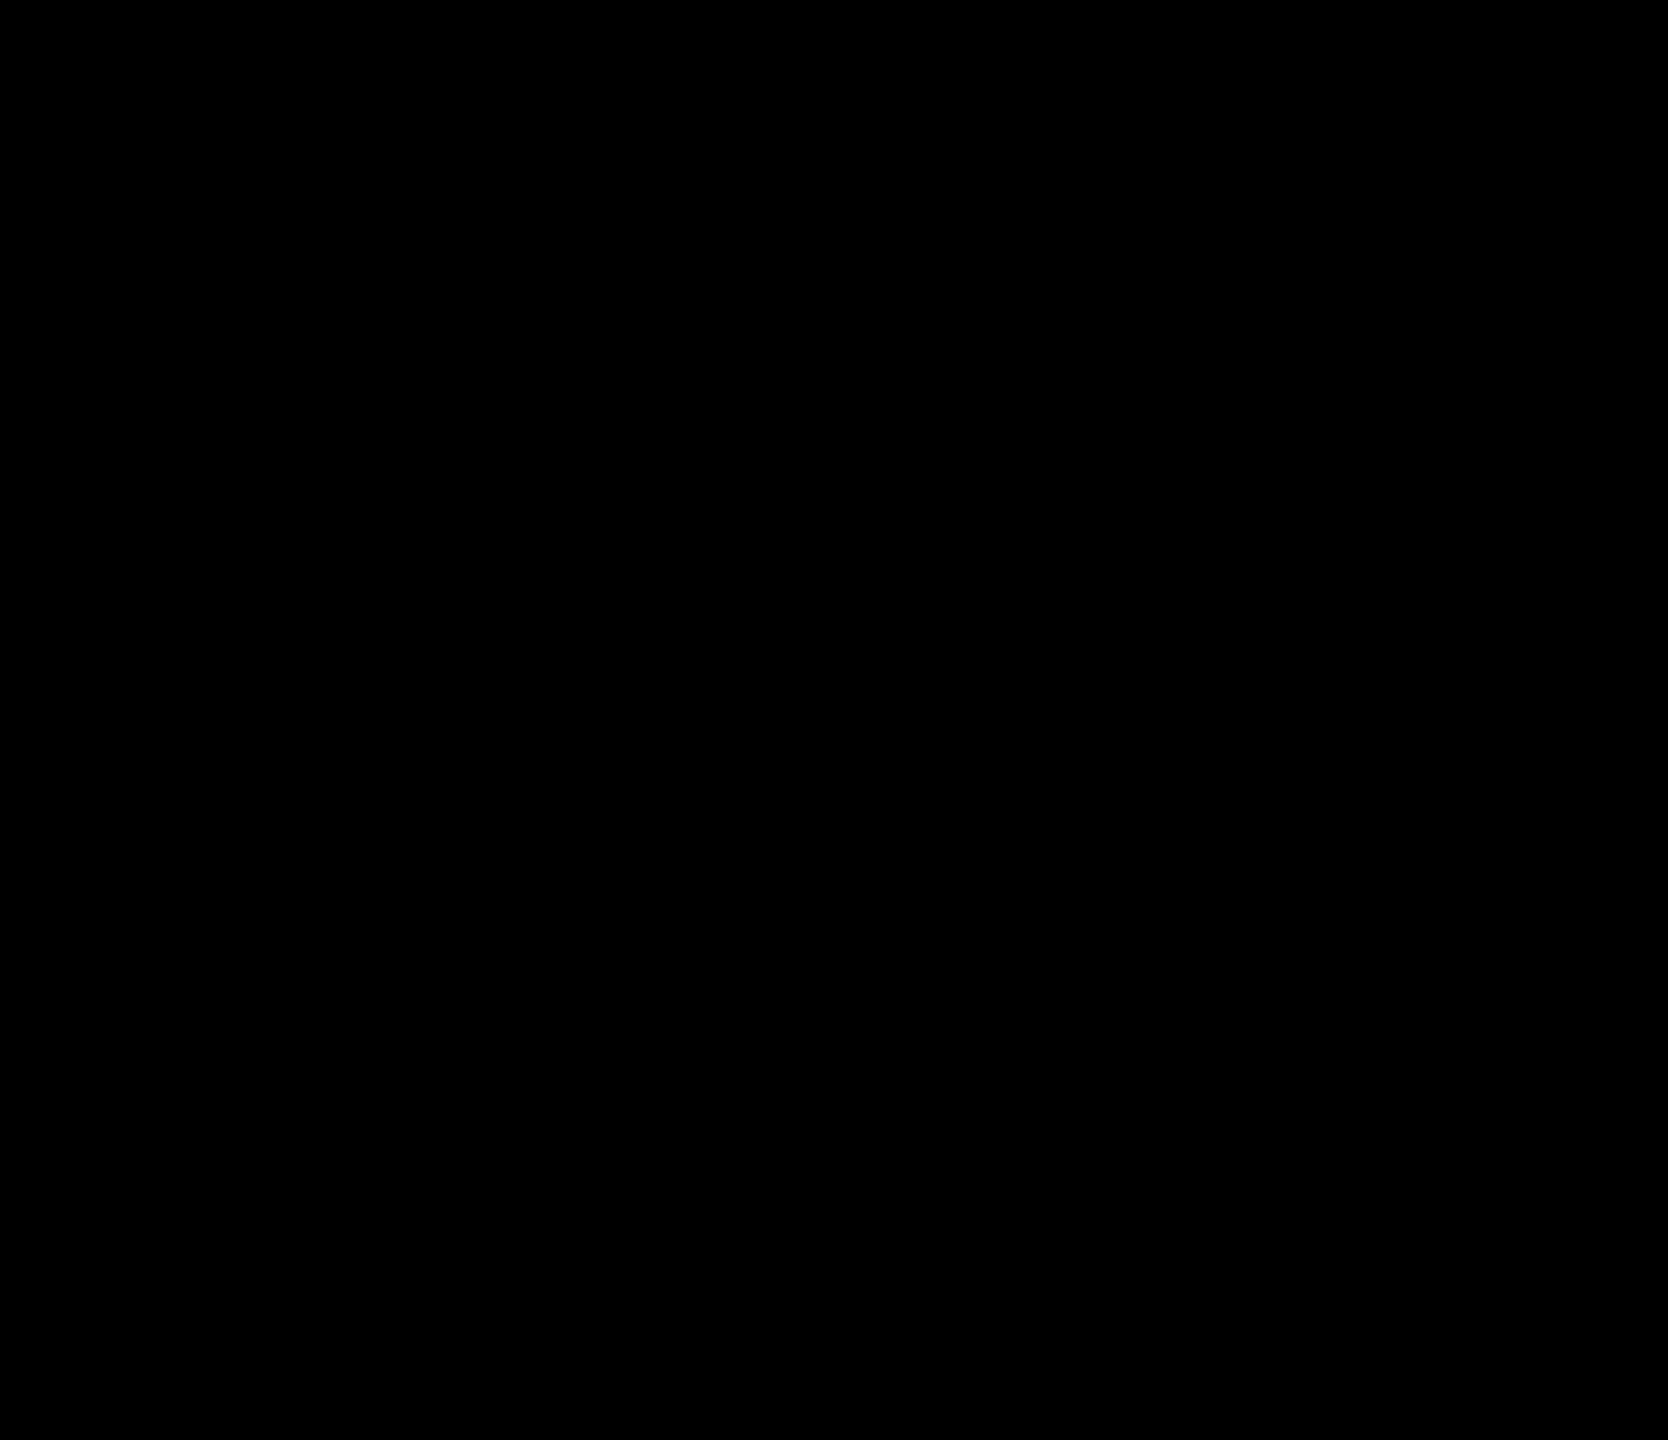
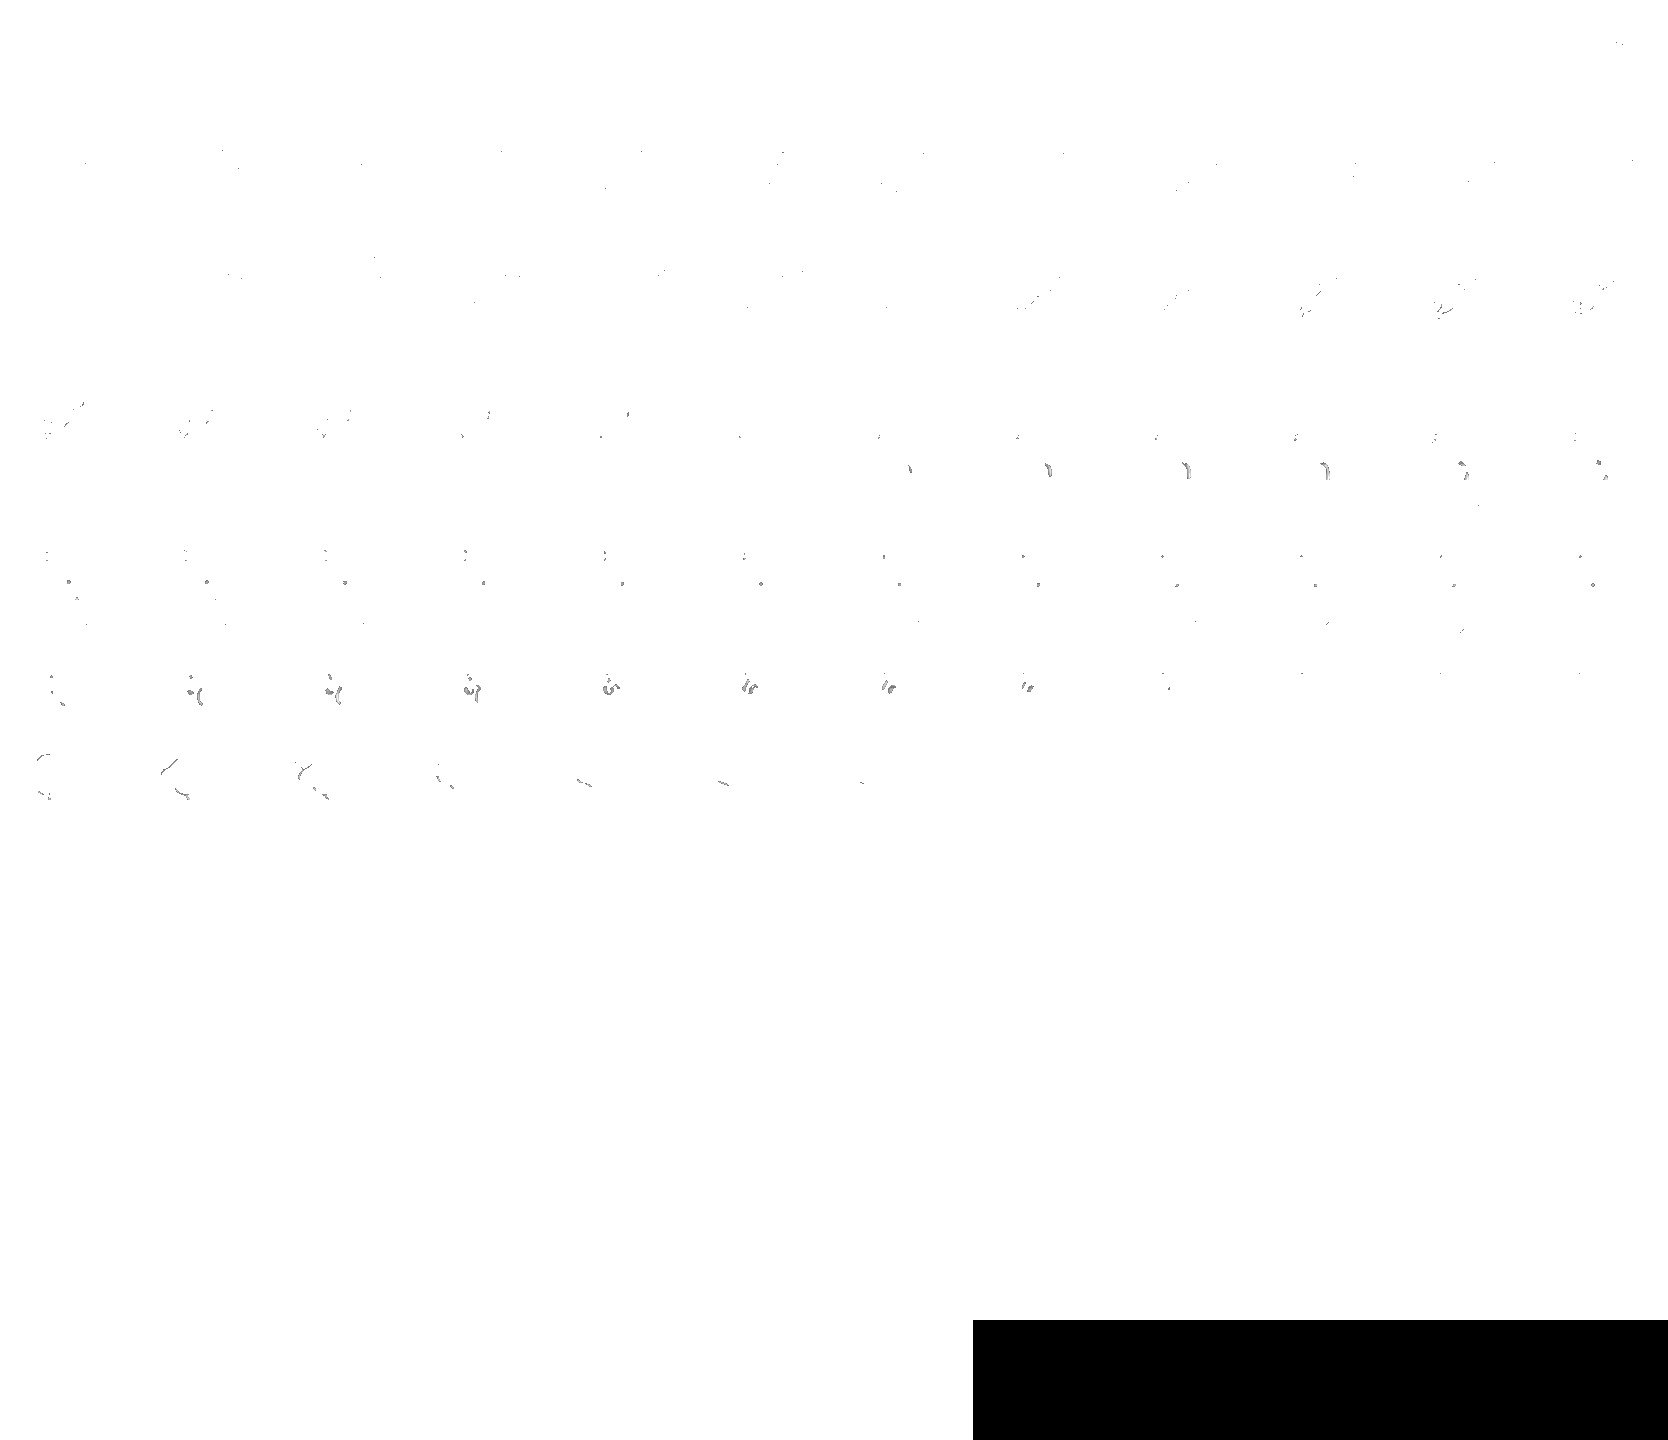

In [13]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

0.0 1.0 None None


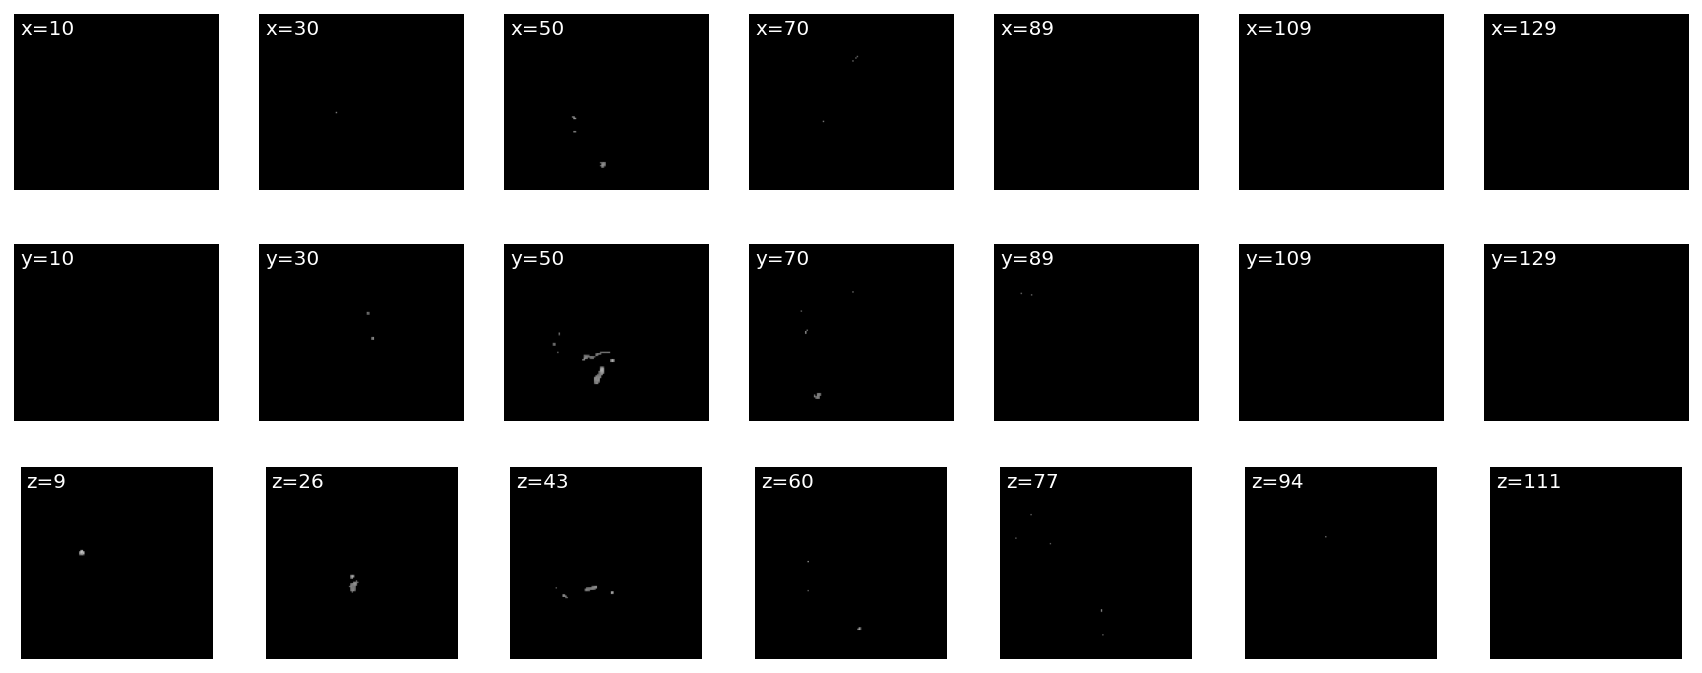

In [14]:
evaluation.plot_slices(mri_imgs_train[0])

## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [20]:
from comet_ml import Optimizer

artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

params = {
    "batch_size": 80,
    "epochs": 2000,
    "learning_rate": 2.6e-5, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.000003, # 1e-3
    "model_name": 'SegNet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 30.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": None,#"ReduceLROnPlateau", # "ReduceLROnP
    "debug":False,
    "dropout":0.38,
    "start_radius":0.2*int(most_common_shape[0]),
    "sample_rate1":0.2,
    "sample_rate2":0.25
    
}
params.update(dataset_params)
params.update(preprocessing_params)
config = {
    # We pick the Bayes algorithm:
    "algorithm": "bayes",
    # Declare your hyperparameters in the Vizier-inspired format:
    "parameters": {
#         "criterion_weights": {"type": "integer", "scalingType": "loguniform", "min": 1, "max": 10000},
#         "weight_decay": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e-3},
#         "learning_rate": {"type": "float", "scalingType": "loguniform", "min": 1e-10, "max": 1e2},
#         "scheduler": {"type": "categorical", "values": ["ReduceLROnPlateau", ""]},
#         "dropout":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.5},
        "start_radius":{"type":"float","scalingType":"loguniform","min":(0.1*int(most_common_shape[0])),"max":(0.4*int(most_common_shape[0]))},
        "sample_rate1":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.4},
        "sample_rate2":{"type":"float","scalingType":"loguniform","min":0.1,"max":0.4}
    },
    # Declare what we will be optimizing, and how:
    "spec": {"metric": "val_bal_acc", "objective": "maximize"},  #test balance accuracy
}


opt = Optimizer(config, api_key=env.cached_data["comet_key"])

COMET INFO: COMET_OPTIMIZER_ID=f6aa945448c84274a27e9a84916e41f1
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': 'f6aa945448c84274a27e9a84916e41f1', 'lastUpdateTime': None, 'maxCombo': 0, 'name': 'f6aa945448c84274a27e9a84916e41f1', 'parameters': {'sample_rate1': {'max': 0.4, 'min': 0.1, 'scalingType': 'loguniform', 'type': 'float'}, 'sample_rate2': {'max': 0.4, 'min': 0.1, 'scalingType': 'loguniform', 'type': 'float'}, 'start_radius': {'max': 55.6, 'min': 13.9, 'scalingType': 'loguniform', 'type': 'float'}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 0, 'metric': 'val_bal_acc', 'minSampleSize': 100, 'objective': 'maximize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 12624871147, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_retry_count': 0}, 'status': 'running', 'suggestion_count': 0, 'trials': 1, 'version': '2.0.1'}


In [19]:
# Finally, get experiments, and train your models:
for comet_exp in opt.get_experiments(project_name=env.project + "-" + params["prediction"]):
    print(comet_exp)
    param_copy = params.copy()
    comet_exp.params
    for key in config["parameters"].keys():
        param_copy[key]=comet_exp.get_parameter(key)
        print(key, param_copy[key])
#     param_copy["weight_decay"] = comet_exp.get_parameter("weight_decay")
#     param_copy["criterion_weights"] = comet_exp.get_parameter("criterion_weights")
#     param_copy["learning_rate"] = comet_exp.get_parameter("learning_rate")
#     param_copy["scheduler"] = comet_exp.get_parameter("scheduler")

    exp = env.create_experiment(
        params["prediction"] + "-pytorch-" + params["model_name"], comet_exp
    ) #params["selected_label"] + "-hyperopt-" + params["model_name"]
    exp.run(training.train_pytorch_model, param_copy, artifacts)


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/60efed7a329d4c49919ea391ba7d9a07



start_radius 0.1282132611317056
sample_rate1 0.1602618935180215
sample_rate2 0.1179573761088609
[INFO] Experiment mask-pytorch-SegNet is initialized.
[INFO] Running experiment: 2021-06-17-00-16-47_mask-pytorch-segnet
Number of Classes 2
Selected model: SegNet
Processing...
Done!
Processing...
Done!
Processing...
Done!
[INFO] Train dataset loaded. Length: 75
[INFO] Validation dataset loaded. Length: 9
[INFO] Engine run starting with max_epochs=2000.
[ERROR] Current run is terminating due to exception: CUDA out of memory. Tried to allocate 282.00 MiB (GPU 0; 10.76 GiB total capacity; 7.62 GiB already allocated; 181.56 MiB free; 7.67 GiB reserved in total by PyTorch)
[ERROR] Engine run is terminating due to exception: CUDA out of memory. Tried to allocate 282.00 MiB (GPU 0; 10.76 GiB total capacity; 7.62 GiB already allocated; 181.56 MiB free; 7.67 GiB reserved in total by PyTorch)
[INFO] Experiment run failed: mask-pytorch-SegNet. Duration: 8 seconds


COMET INFO: Optimizer metrics is 'bal_acc' but no logged values found. Experiment ignored in sweep.
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/60efed7a329d4c49919ea391ba7d9a07
COMET INFO:   Others:
COMET INFO:     Name                   : 2021-06-17-00-16-47_mask-pytorch-segnet
COMET INFO:     optimizer_count        : 3
COMET INFO:     optimizer_id           : b47f59109e454d88869a30c9badbde18
COMET INFO:     optimizer_metric       : bal_acc
COMET INFO:     optimizer_metric_value : 1
COMET INFO:     optimizer_objective    : minimum
COMET INFO:     optimizer_parameters   : {"sample_rate1": 0.1602618935180215, "sample_rate2": 0.1179573761088609, "start_radius": 0.1282132611317056}
COMET INFO:     optimizer_pid          : 82b9fe25dbdc9b4b382a2db5441a74d37d459b0a
C

RuntimeError: CUDA out of memory. Tried to allocate 282.00 MiB (GPU 0; 10.76 GiB total capacity; 7.62 GiB already allocated; 181.56 MiB free; 7.67 GiB reserved in total by PyTorch)

## Evaluate Model

Do evaluation, e.g. visualizations  

In [18]:
from aneurysm_utils.utils.pytorch_utils import predict

In [19]:
model = exp.artifacts["model"]

In [20]:
predictions = predict(model, mri_imgs_val, apply_softmax=False )

ValueError: too many values to unpack (expected 5)

In [ ]:
predictions[0][1]

In [ ]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [ ]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)